In [1]:
import sys
import data_loader
from fusers import unet, nn
from models import Net
import torchvision.models.swin_transformer as st
from torchvision import transforms
import torch
torch.set_num_threads(2)
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import argparse

In [2]:
img_num = {
        'csiq':     list(range(0, 30)),
        'kadid10k': list(range(0, 80)),
        'tid2013':  list(range(0, 25)),
        'koniq':    list(range(0, 10073)),
        'spaq':     list(range(0, 11125)),
        'pipal':    list(range(0, 200)),
        'biq':      list(range(0, 11989))
        }

In [21]:
len(train_test_split(img_num['biq'], test_size=0.5, random_state=42)[0])*2

11988

In [30]:
# unet fuser
k = 3
device = "cpu"
model = unet.IQAUNetModel(
    image_size=(224, 224),
    in_channels= 3*(k+1),
    model_channels=64,
    out_channels=3,
    k = k,
    num_res_blocks=1,
    attention_resolutions= (20,),
    num_heads=4,
    resblock_updown=False,
    conv_resample=True,
    first_conv_resample=False,
    channel_mult=(1,1.5),
    scaling_factors=(2,2,2),
    middle_attention=True
).to(device)

2
4
4
4
2
2


In [232]:
k = 6
class SinFuser(torch.nn.Module):
    def __init__(self, k: int, before_initial_conv: bool):
        super().__init__()
        self.k = k
        self.before_initial_conv = before_initial_conv 

        # modules
        self.initial_conv = torch.nn.Conv2d(3*(k+1), 3, kernel_size=(1, 1), bias=0)
        if before_initial_conv:
            self.post_process = torch.nn.Conv2d(
                3*k, 3*k, (3,3), padding=(1,1)
            )
        else:
            self.post_process = torch.nn.Conv2d(
                3, 3, (3,3), padding=(1,1)
            )
        self.nonlinearity = torch.nn.SiLU()
     
    def forward(self, x, y):
        if self.before_initial_conv:
            embeds = nn.timestep_embedding(timesteps=y, dim=3*224*224).reshape([
                x.shape[0], self.k * 3, 224, 224
            ])
            embeds = self.post_process(embeds)
            embeds = self.nonlinearity(embeds)
            embeds = torch.cat([ torch.zeros([x.shape[0], 3, 224, 224], device=x.device), embeds ], dim=1)
            x = x + embeds
            res = self.initial_conv(x)
            return self.nonlinearity(res)
        else:
            embeds = nn.timestep_embedding(timesteps=y, dim=3*224*224//self.k).reshape([
                x.shape[0], 3, 224, 224
            ])
            embeds = self.post_process(embeds)
            embeds = self.nonlinearity(embeds)
            x = self.initial_conv(x)
            res = x + embeds
            return self.nonlinearity(res)

model = SinFuser(
    k=k, before_initial_conv=1
).to("cuda:3")

In [4]:
# swin fuser
k = 3
device = "cuda:3"
model = st.SwinTransformerBlockV2(
    dim=3*(k+1),
    num_heads=4,
    window_size=[7,7],
    shift_size=[1,1]
)

In [33]:
# TReSM
config = argparse.Namespace()
config.num_encoder_layerst = 2
config.dim_feedforwardt = 64
config.nheadt = 16
config.network = 'resnet50'
config.k = 3
config.middle_fuse = 1
config.multi_return = 0
config.finetune = 0
config.single_channel = 1
config.double_branch = 0
config.unet = 0
config.sin = 0
config.before_conv_in_sin = 0
config.multi_ranking = 0
config.resume = 0
config.scaling_factors = [4,1,2,2]
config.middle_attention = 1
config.attention_resolutions = [4, 8]
config.first_conv_resample = 0
config.model_channels = 32
config.channel_mult = [1,2,4]
config.conv_bias = 0
config.late_fuse = 0

model = Net(
    config, "cpu"
)
# checkpoint = torch.load("/home/sharfikeg/my_files/extra_disk_1/Save_SinTReSS/koniq_1_1/k_3/lr_0.00076875_lrratio0.5/no_finetune/single_return/bestmodel_1_1", map_location="cpu")
# model.load_state_dict(checkpoint)
fuser = model.initial_fuser

In [5]:
train , test = train_test_split( img_num['koniq'], test_size=0.2, random_state=1)
loader = data_loader.DataLoader(
    dataset='koniq',
    path="/home/s-kastryulin/data/koniq10k",
    img_indx=train,
    patch_num=50,
    patch_size=224, seed=1, k=3, batch_size=1, istrain=True
)

In [17]:
# X = torch.rand([64, 3*(k+1), 224, 224])
# y = torch.rand([64, k+1])
for X,y in loader.get_data():
    print(X.shape, y.shape)
    y = y.to("cpu")
    res = fuser(X.to("cpu"), y[::, 1:])
    break

torch.Size([1, 12, 224, 224]) torch.Size([1, 4])


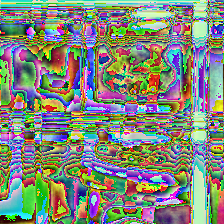

In [21]:
to_pil = transforms.ToPILImage()
to_pil(res[0])

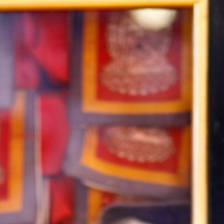

In [19]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)
to_pil(inv_normalize( X[0][:3, ...]) )

In [34]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

152452309

In [4]:
optim = torch.optim.SGD(params=model.parameters(), lr=6e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer=optim, T_0=3, T_mult=2, eta_min=6e-5
# )
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optim, T_max=3, eta_min=6e-5
)
scheduler2 = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.9)

[0.0006]
[0.0004649999999999999]
[0.00019500000000000002]
[6e-05]
[0.00012749999999999998]
[0.00032250000000000025]
[0.0004200000000000003]
[0.0003187500000000003]
[0.00011625000000000024]
[1.5e-05]
[3.1874999999999996e-05]
[8.062499999999991e-05]
[0.00010499999999999994]
[7.968749999999995e-05]
[2.9062500000000036e-05]
[3.75e-06]
[7.968749999999999e-06]
[2.015625000000006e-05]
[2.6250000000000072e-05]
[1.9921875000000076e-05]


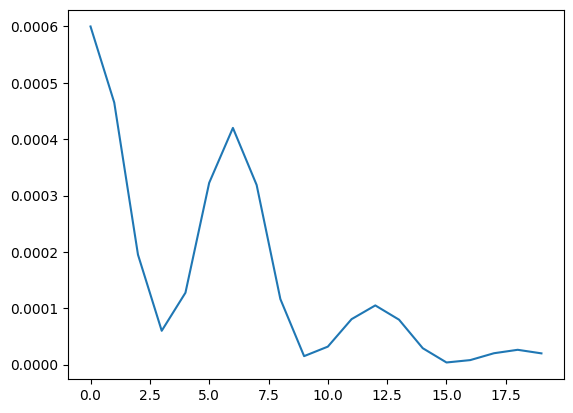

In [83]:
x = []
y = []
for i in range(20):
    print(scheduler.get_last_lr())
    x.append(i)
    y.append(scheduler.get_last_lr()[0] )
    scheduler.step()
    if (i+1) % 3 == 0:
        scheduler.eta_min = scheduler.eta_min * 0.5
    if (i+1+3) % 3 == 0:
        scheduler.base_lrs[0] = scheduler.base_lrs[0] * 0.5
plt.plot(x,y)
plt.show()

In [49]:
a = torch.rand([16, 3*(3+1), 32, 32])
a[1,:3] == a.reshape([16*(3+1), 3, 32, 32])[4]

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]]

In [2]:
# TabR fusion
labels = torch.rand([16, 5, 1])
test_features = torch.rand([16, 2048])
nn_features = torch.rand([16, 5, 2048])
W_x = torch.nn.Linear(in_features=2048, out_features=512)
W_y = torch.nn.Linear(in_features=1, out_features=2048)
T = torch.nn.Sequential(
    torch.nn.Linear(in_features=512, out_features=1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(in_features=1024, out_features=2048, bias=False),
)

In [15]:
(T(W_x(test_features)[:, None, :] - W_x(nn_features)) + W_y(labels)).sum(dim=1).shape

torch.Size([16, 2048])

In [51]:
a = torch.tensor([
    0.9178, 0.9129, 0.8216, 0.7811, 0.9136
]).mean()

b = torch.tensor([
    0.9227, 0.8936, 0.8699, 0.8362, 0.8928
]).mean()

In [36]:
y[:, 1:, :].shape

torch.Size([52, 5, 2048])